In [ ]:
library(Seurat)
library(org.Hs.eg.db)
library(clusterProfiler)
library(patchwork)
library(dplyr)
library(RColorBrewer)
library(ggplot2)
library(cowplot)
library(ggpubr)
library(readr)
library(tidyr)
library(ggforce)
library(pals)
library(pheatmap)
library(scales)
library(ggthemes)
library(clustree)
library(ComplexHeatmap)
library(circlize)
library(ggrastr)
library(ggrepel)

In [54]:
setwd("/mnt/public3/chaohy/pancancer/fig2")
rds <- readRDS("CellRes.GSE205013_CCA_ref_20240109.int.rds")
metadata <- readRDS("20240107_Integ.final.metadata.rds")
rds@meta.data<-metadata

In [ ]:
colors_jo <- read.table("/mnt/public3/chaohy/pancancer/plot1cell/colors_jo.txt", sep="\t", header=T,comment.char = "")

colors_jo$primary_cluster <- factor(colors_jo$primary_cluster,levels = unique(colors_jo$primary_cluster))
markers_color = setNames(unique(colors_jo$primary_color), names(table(colors_jo$primary_cluster)))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



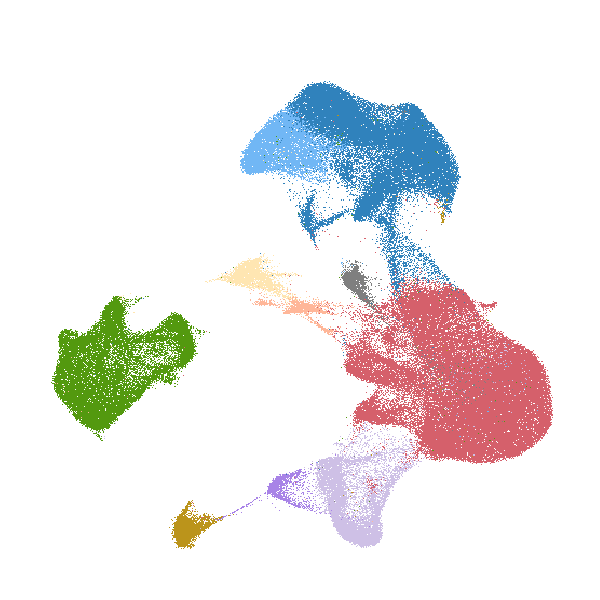

In [54]:
options(repr.plot.width=5, repr.plot.height=5)
DimPlot(rds, label=F, label.box=F,label.size = 5, group.by ="primary_cluster",cols = markers_color) + NoLegend() +
theme(axis.line = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), axis.title = element_blank())+
labs(title = "")+ theme(plot.title = element_text(hjust = 0.5,size = 15,face="bold" )) -> p1
p1

In [16]:
rdsPCs <- readRDS("CellRes.GSE205013_CCA_ref_20240108.protein_coding.rds")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



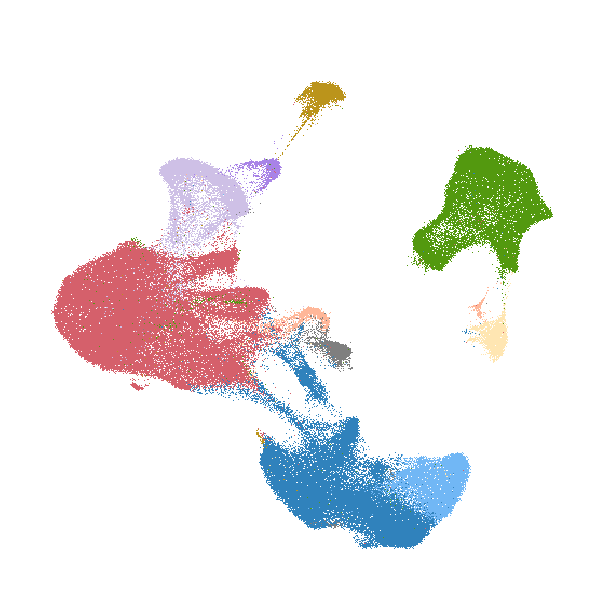

In [81]:
options(repr.plot.width=5, repr.plot.height=5)
DimPlot(rdsPCs, label=F, label.box=F,label.size = 5, group.by ="primary_cluster_manual",cols = markers_color) + NoLegend() +
theme(axis.line = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), axis.title = element_blank())+
labs(title = "")+ theme(plot.title = element_text(hjust = 0.5,size = 15,face="bold" )) -> p2
p2

In [47]:
rdsLnc <- readRDS("CellRes.GSE205013_CCA_ref_20240108.lncRNA.rds")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



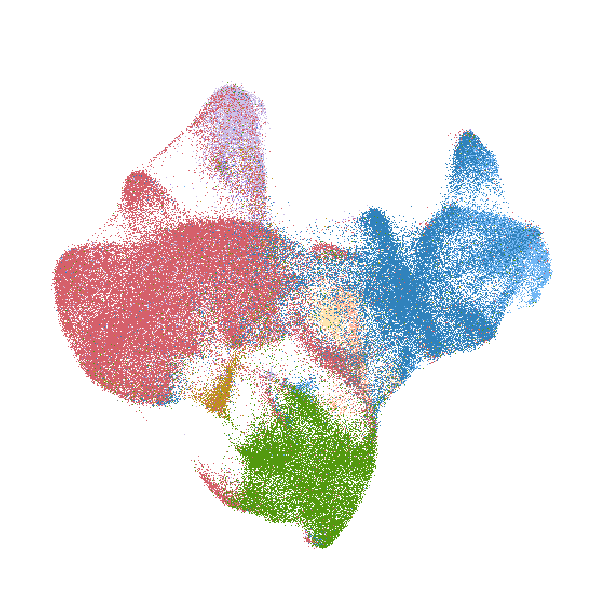

In [82]:
options(repr.plot.width=5, repr.plot.height=5)
DimPlot(rdsLnc, label=F, label.box=F,label.size = 5, group.by ="primary_cluster",cols = markers_color) + NoLegend() +
theme(axis.line = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), axis.title = element_blank())+
labs(title = "")+ theme(plot.title = element_text(hjust = 0.5,size = 15,face="bold" )) -> p3
p3

png 
  2

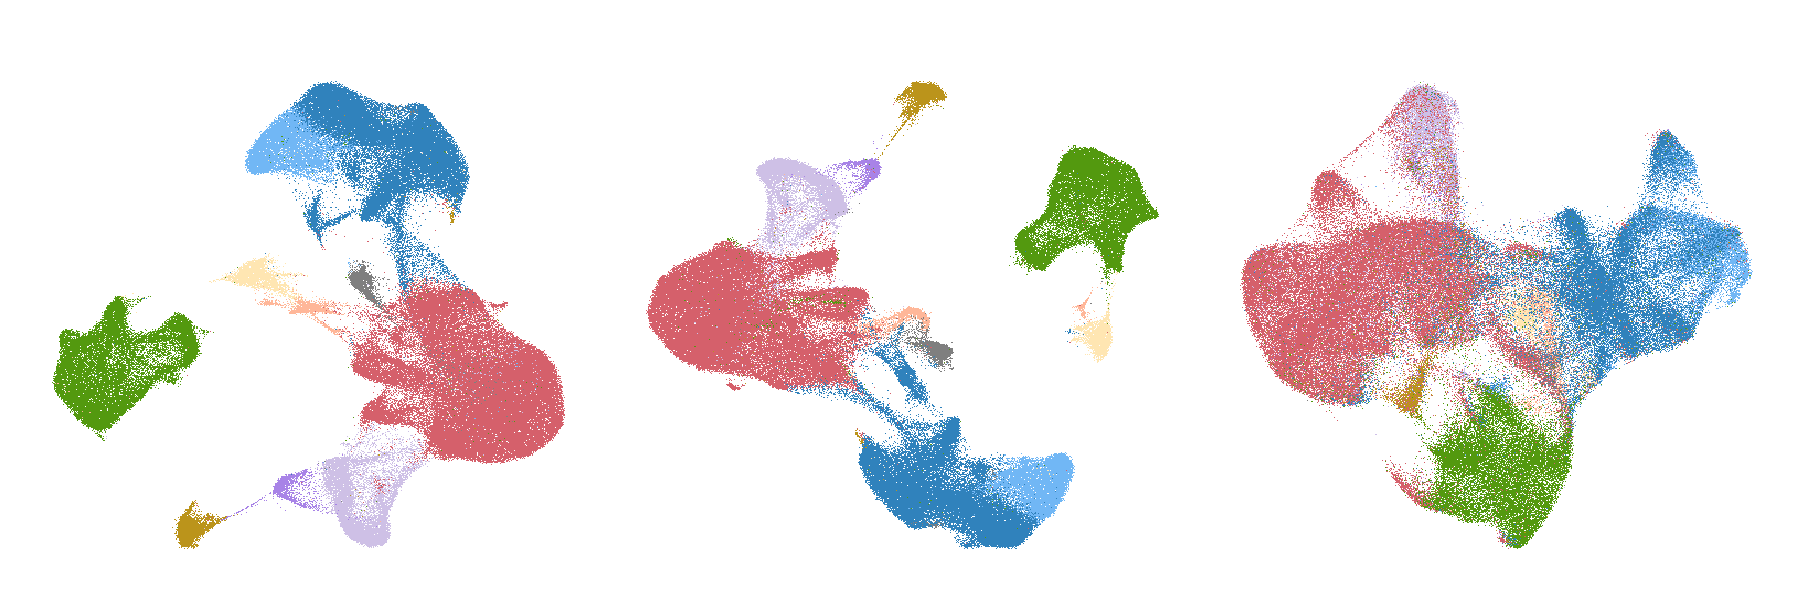

In [83]:
options(repr.plot.width=15, repr.plot.height=5)
p1 + p2 + p3 + plot_layout(nrow = 1)
pdf("Fig2a.pdf", width=15, height=5)
p1 + p2 + p3 + plot_layout(nrow = 1)
dev.off()

In [7]:
rdsjo <- readRDS("/mnt/public3/chaohy/pancancer/plot1cell/20240103_Integ.final_UMAP_Clean.rds")
rdsjo_meta <- readRDS("/mnt/public3/chaohy/pancancer/plot1cell/20240107_Integ.final.metadata.rds")
rdsjo@meta.data <- rdsjo_meta

png 
  2

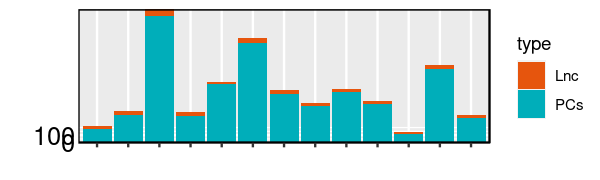

In [ ]:
read.csv("/mnt/public3/chaohy/pancancer/fig2/prim_markerGenes_jo.csv", header=T) -> primary_cluster_DEGs
read.table("/mnt/public3/chaohy/pancancer/fig2/gene.bed", sep="\t", header=F) -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC
# 过滤
primary_cluster_DEGs[primary_cluster_DEGs$p_val_adj < 0.05,] %>%  dplyr::filter(pct.1>0.2 & pct.2<pct.1) -> primary_cluster_DEGs
# 提取primary_cluster_DEGs的name列为"NA"的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_PC$V4,]  -> primary_cluster_PCs
# 提取primary_cluster_DEGs的name列不为"NA"的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_lncRNA$V4,] -> primary_cluster_Lnc
# 统计primary_cluster_PCs中根据cluster分类的基因数目
primary_cluster_PCs %>% group_by(cluster) %>% summarise(PCs=n()) -> primary_cluster_PCs
primary_cluster_Lnc %>% group_by(cluster) %>% summarise(Lnc=n()) -> primary_cluster_Lnc
# 合并primary_cluster_PCs和primary_cluster_Lnc
merge(primary_cluster_PCs, primary_cluster_Lnc, by="cluster") -> PCs_Lnc_numStat
# 将数量转换为百分比
# PCs_Lnc_numStat[,2:3] <- PCs_Lnc_numStat[,2:3] * 100 / rowSums(PCs_Lnc_numStat[,2:3])

cell_list <- c("Acinar cell","B cell","Ductal cell","Endocrine cell","Endothelial cell","Fibroblast","Hepatocytes","Mast cell","Myeloid","NK","Plasma cell","Stellate cell","T cell")

# 将PCs_Lnc_numStat数据转换为长格式
gathered_data <- gather(PCs_Lnc_numStat, key="type", value="num", -cluster)
# 将cluster列转换为因子
gathered_data$cluster <- factor(gathered_data$cluster, levels=cell_list)
# 百分比堆叠柱状图
options(repr.plot.width=5, repr.plot.height=1.5)
ggplot(gathered_data, aes(x = cluster, y = num, fill = type)) + 
  geom_bar(stat = "identity", position = "stack") + 
  scale_y_continuous(expand = c(0, 0), breaks = seq(0, 100, 100)) +
  scale_fill_manual(values = c("#e6550d", "#00aeba")) + 
  theme(legend.position = "right",
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 15, colour = "black"),
        axis.ticks.length.y = unit(0, "cm"),
        panel.border = element_rect(color = "black", fill = NA)) + 
  labs(x = "", y = "") -> p1
p1
pdf("Fig2b1.pdf", width=5, height=1.5)
p1
dev.off()

In [437]:
read.csv("/mnt/public3/chaohy/pancancer/fig2/prim_markerGenes_jo.csv", header=T) -> primary_cluster_DEGs
read.table("/mnt/public3/chaohy/pancancer/fig2/gene.bed", sep="\t", header=F) -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
# gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC
# 过滤
primary_cluster_DEGs[primary_cluster_DEGs$p_val_adj < 0.05,] %>%  dplyr::filter(pct.1>0.2 & pct.2<pct.1) -> primary_cluster_DEGs
# 提取PCs所在的行
# primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_PC$V4,] %>% arrange(cluster)  -> primary_cluster_PCs
# 提取Lnc所在的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_lncRNA$V4,] %>% arrange(cluster) -> primary_cluster_Lnc

# # 统计所有LncRNA数目
# primary_cluster_Lnc %>% group_by(cluster) %>% summarise(Lnc=n())
# # 统计所有有名的LncRNA数目
# primary_cluster_Lnc %>% group_by(cluster) %>% dplyr::filter(!grepl("HSALNG",gene)) %>% summarise(Lnc=n())
# primary_cluster_Lnc %>% head()

# 对rdsjo计算差异lncRNA在各个primary_cluster中的平均表达量
avgExp0 <- AverageExpression(rdsjo, features = unique(primary_cluster_Lnc$gene), group.by = 'primary_cluster', assays = 'SCT')$SCT
# 对平均表达量进行标准化，使画图时颜色对比更加明显
markerExp <- t(apply(avgExp0, 1, scale))
colnames(markerExp) <- colnames(avgExp0)

In [438]:
# 对有名的Lnc去重，取top2，用于展示在图右侧
primary_cluster_Lnc %>% dplyr::filter(!grepl("HSALNG",gene)) %>% distinct(gene, .keep_all = TRUE) %>% group_by(cluster) %>% top_n(2, pct.diff) %>% arrange(cluster) -> primary_cluster_Lnc_top2
gene_pos <- which(rownames(markerExp) %in% primary_cluster_Lnc_top2$gene)
row_anno <- rowAnnotation(gene=anno_mark(at=gene_pos,labels = primary_cluster_Lnc_top2$gene))

png 
  2

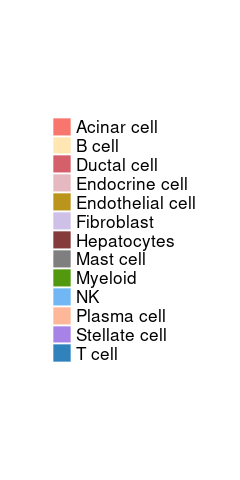

In [450]:
##设置列标签的颜色，最好和umap/tsne细胞群的颜色一一对应 
colors_jo <- read.table("/mnt/public3/chaohy/pancancer/plot1cell/colors_jo.txt", sep="\t", header=T,comment.char = "")
colors_jo %>% arrange(primary_cluster) -> colors_jo
col <- unique(colors_jo$primary_color)
cluster_info <- unique(colors_jo$primary_cluster)
setNames(col, cluster_info) -> col
options(repr.plot.width=2, repr.plot.height=4)
draw(Legend(labels = unique(colors_jo$primary_cluster),legend_gp = gpar(fill = col)))
pdf("Fig2bPlegend.pdf", width=2, height=4)
draw(Legend(labels = unique(colors_jo$primary_cluster),legend_gp = gpar(fill = col)))
dev.off()

In [441]:
PCs_Lnc_numStat[,3]

[1] 19 43 84 42 21 54 36 25 24 26 12 39 24

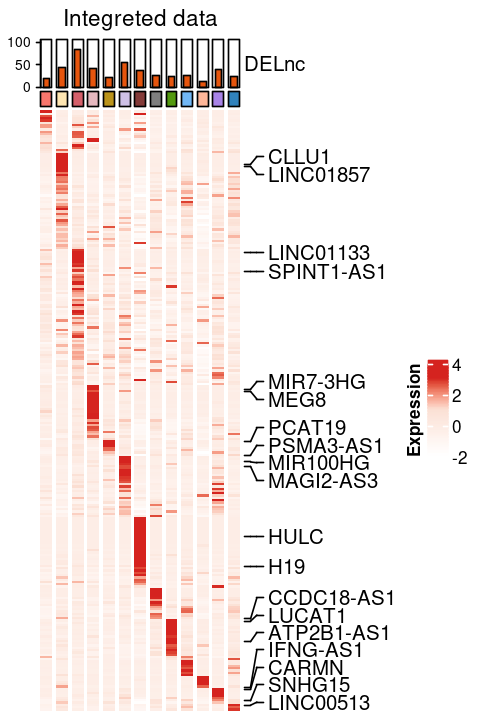

In [447]:
options(repr.plot.width=4, repr.plot.height=6)
ha = HeatmapAnnotation(DELnc = anno_barplot(PCs_Lnc_numStat[,3],gp = gpar(fill = "#e6550d"),ylim = c(0,100)),
                      cluster = anno_block(gp = gpar(fill = unique(colors_jo$primary_color))),
                      annotation_height = unit(c(1,0.3), "cm"),
                      gap = unit(1, "mm"))

Heatmap(markerExp,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_column_names = FALSE,
        show_row_names = FALSE,
        column_split = cluster_info,
        column_title = "Integreted data",
        top_annotation = ha,
        right_annotation = row_anno,
        heatmap_legend_param = list(
          title='Expression',
          title_position='leftcenter-rot'),
        col = colorRamp2(c(-2, 1, 3), c("white","#fbe0d4", "#d5231f"))
        )

In [448]:
read.csv("/mnt/public3/chaohy/pancancer/fig2/DEG_results_int/primary_cluster_markerGenes.csv", header=T) -> primary_cluster_DEGs
read.table("/mnt/public3/chaohy/pancancer/fig2/gene.bed", sep="\t", header=F) -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC
# 过滤
primary_cluster_DEGs[primary_cluster_DEGs$p_val_adj < 0.05,] %>%  dplyr::filter(pct.1>0.2 & pct.2<pct.1) -> primary_cluster_DEGs
# 提取PCs所在的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_PC$V4,] %>% arrange(cluster)  -> primary_cluster_PCs
# 提取Lnc所在的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_lncRNA$V4,] %>% arrange(cluster) -> primary_cluster_Lnc_yu

# 提取primary_cluster_Lnc_yu和primary_cluster_Lnc的交集
primary_cluster_Lnc_yu %>% dplyr::filter(gene %in% primary_cluster_Lnc$gene) %>% distinct(gene, .keep_all = TRUE) -> primary_cluster_Lnc_jo_yu
# 提取top2的Lnc
primary_cluster_Lnc_jo_yu %>% group_by(cluster) %>% top_n(1, pct.diff) %>% arrange(cluster) -> primary_cluster_Lnc_jo_yu_top2

# 对有名的Lnc和top的去重，用于展示在图右侧
double_genes <- unique(c(primary_cluster_Lnc_top2$gene,primary_cluster_Lnc_jo_yu_top2$gene))
double_genes <- markerExp[which(rownames(markerExp) %in% double_genes),]
double_genes_pos <- which(rownames(markerExp) %in% rownames(double_genes))
row_anno <- rowAnnotation(gene=anno_mark(at=double_genes_pos, labels = rownames(double_genes)))

png 
  2

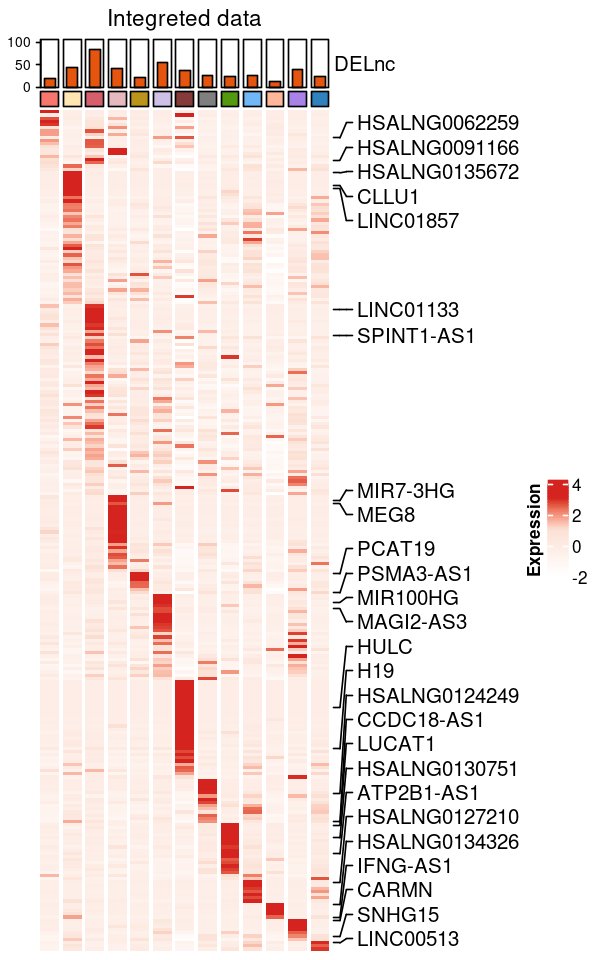

In [449]:
options(repr.plot.width=5, repr.plot.height=8)
Heatmap(markerExp,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_column_names = FALSE,
        show_row_names = FALSE,
        column_split = cluster_info,
        column_title = "Integreted data",
        top_annotation = ha,
        right_annotation = row_anno,
        heatmap_legend_param = list(
          title='Expression',
          title_position='leftcenter-rot'),
        col = colorRamp2(c(-2, 1, 3), c("white","#fbe0d4", "#d5231f"))
        ) -> p2
p2
pdf("Fig2b2.pdf", width=5, height=8)
p2
dev.off()

In [463]:
rdsLnc<- readRDS("/mnt/public3/chaohy/pancancer/fig2/20240109_lnc.final_UMAP_Clean.rds")


In [486]:
rdsLncyu<- readRDS("/mnt/public3/chaohy/pancancer/fig2/CellRes.GSE205013_CCA_ref_20240109.lncRNA.rds")

In [616]:
DefaultAssay(rdsjo) <- "RNA"
DefaultAssay(rdsLnc) <- "RNA"
DefaultAssay(rdsLncyu) <- "RNA"
DefaultAssay(rds) <- "RNA"

In [612]:
DefaultAssay(rdsjo) <- "SCT"
DefaultAssay(rdsLnc) <- "SCT"
DefaultAssay(rdsLncyu) <- "SCT"
DefaultAssay(rds) <- "SCT"

In [575]:
plot_gene_features <- function(gene1, gene2) {
  p <- list()

  plot_gene <- function(rds, gene, colors) {
    FeaturePlot(rds, features = gene, reduction = 'umap',order=TRUE, cols=rev(brewer.spectral(7)), combine = TRUE, pt.size=2, raster = T) +
      NoLegend() +
      theme(axis.line = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), axis.title = element_blank()) +
      labs(title = bquote(italic(.(gene)))) +
      theme(plot.title = element_text(hjust = 0, vjust = 0, size = 40))
  }

  p[[1]] <- plot_gene(rdsjo, gene1, c('#f0f0ee', '#831fd5', limits=c(1,7)))
  p[[2]] <- plot_gene(rdsjo, gene2, c('#f0f0ee', '#d5231f', limits=c(1,7)))
  p[[3]] <- plot_gene(rdsLnc, gene2, c('#f0f0ee', '#d5231f', limits=c(1,7)))
  p[[4]] <- plot_gene(rds, gene2, c('#f0f0ee', '#218d8f', limits=c(1,7)))
  p[[5]] <- plot_gene(rdsLncyu, gene2, c('#f0f0ee', '#218d8f', limits=c(1,7)))

  options(repr.plot.width = 25, repr.plot.height = 5)
  combined_plot <- plot_grid(plotlist = p, nrow = 1, ncol = 5)

  pdf(paste("Fig2b_", gene1, "_", gene2, ".pdf", sep = ""), width = 25, height = 5)
  print(combined_plot)
  dev.off()

  return(combined_plot)
}

In [726]:
pdf("Fig2cLegend.pdf", width = 6, height = 5)
FeaturePlot(rds, features = "EPCAM", reduction = 'umap',order=TRUE, cols=rev(brewer.spectral(7)), combine = TRUE, pt.size=2, raster = T)
dev.off()

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

In [720]:
#plot_gene_features("MS4A1", "HSALNG0135672") -> p1
#plot_gene_features("MS4A1", "CLLU1") -> p1.1
#plot_gene_features("EPCAM", "HSALNG0091166") -> p2
#plot_gene_features("EPCAM", "HSALNG0091166") -> p2_1 #SCT
#plot_gene_features("EPCAM", "LINC01133") -> p2.1 #GOOD
#plot_gene_features("EPCAM", "HSALNG0086913") -> p2.2
#plot_gene_features("PLVAP", "PCAT19") -> p3
#plot_gene_features("PLVAP", "MAGI2-AS3") -> p3.1 #共表达
#plot_gene_features("LUM", "MIR100HG") -> p4 #不太好
#plot_gene_features("LUM", "HSALNG0062259") -> p4.1
#plot_gene_features("LUM", "MEG8") -> p4.2
#plot_gene_features("CPA3", "HSALNG0124249") -> p5 #非常差
#plot_gene_features("CPA3", "HSALNG0076525") -> p5.3
#plot_gene_features("CPA3", "HSALNG0124249") -> p5_1 #SCT BAD
#plot_gene_features("CPA3", "CCDC18-AS1") -> p5.1 #非常差
#plot_gene_features("CPA3", "ILF3-AS1") -> p5.2 #非常差
#plot_gene_features("CSF3R", "LUCAT1") -> p6 #中性粒
#plot_gene_features("CD68", "HSALNG0134877") -> p6.3
#plot_gene_features("CSF3R", "ATP2B1-AS1") -> p6.1 #中性粒
#plot_gene_features("CD68", "HSALNG0086857") -> p6.2 #巨噬
#plot_gene_features("GNLY", "HSALNG0127210") -> p7 
#plot_gene_features("JCHAIN", "HSALNG0104248") -> p8
#plot_gene_features("RGS5", "CARMN") -> p9
#plot_gene_features("CD3D", "LINC00513") -> p10
#plot_gene_features("CD3D", "HSALNG0089242") -> p10.1
#plot_gene_features("CD3D", "LINC00513") -> p10_1 #SCT
#plot_gene_features("CD3D", "HSALNG0090741") -> p10.2
#plot_gene_features("CD3D", "HSALNG0090741") -> p10_2 #SCT
#plot_gene_features("FOXP3", "HSALNG0016641") -> p11 #Treg
#plot_gene_features("PRSS1", "HSALNG0080861") -> p12
#plot_gene_features("INS", "MIR7-3HG") -> p13 #内分泌


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



In [719]:
DefaultAssay(rdsjo) <- "SCT"
DefaultAssay(rdsLnc) <- "SCT"
DefaultAssay(rdsLncyu) <- "SCT"
DefaultAssay(rds) <- "SCT"

In [704]:
DefaultAssay(rdsjo) <- "RNA"
DefaultAssay(rdsLnc) <- "RNA"
DefaultAssay(rdsLncyu) <- "RNA"
DefaultAssay(rds) <- "RNA"

png 
  2

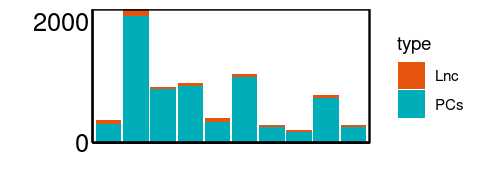

In [451]:
read.csv("/mnt/public3/chaohy/pancancer/fig2/DEG_results_int/primary_cluster_markerGenes.csv", header=T) -> primary_cluster_DEGs
read.table("/mnt/public3/chaohy/pancancer/fig2/gene.bed", sep="\t", header=F) -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC
# 过滤
primary_cluster_DEGs[primary_cluster_DEGs$p_val_adj < 0.05,] %>%  dplyr::filter(pct.1>0.2 & pct.2<pct.1) -> primary_cluster_DEGs
# 提取primary_cluster_DEGs的name列为"NA"的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_PC$V4,]  -> primary_cluster_PCs
# 提取primary_cluster_DEGs的name列不为"NA"的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_lncRNA$V4,] -> primary_cluster_Lnc
# 统计primary_cluster_PCs中根据cluster分类的基因数目
primary_cluster_PCs %>% group_by(cluster) %>% summarise(PCs=n()) -> primary_cluster_PCs
primary_cluster_Lnc %>% group_by(cluster) %>% summarise(Lnc=n()) -> primary_cluster_Lnc
# 合并primary_cluster_PCs和primary_cluster_Lnc
merge(primary_cluster_PCs, primary_cluster_Lnc, by="cluster") -> PCs_Lnc_numStat
# 将数量转换为百分比
#PCs_Lnc_numStat[,2:3] <- PCs_Lnc_numStat[,2:3] * 100 / rowSums(PCs_Lnc_numStat[,2:3])

cell_list <- c("B cell","Ductal cell","Endothelial cell","Fibroblast","Mast cell","Myeloid","NK","Plasma cell","Stellate cell","T cell")

# 将PCs_Lnc_numStat数据转换为长格式
gathered_data <- gather(PCs_Lnc_numStat, key="type", value="num", -cluster)
# 将cluster列转换为因子
gathered_data$cluster <- factor(gathered_data$cluster, levels=cell_list)

# 百分比堆叠柱状图
options(repr.plot.width=4, repr.plot.height=1.5)
ggplot(gathered_data, aes(x = cluster, y = num, fill = type)) + 
  geom_bar(stat = "identity", position = "stack") + 
  theme_classic() +
  scale_y_continuous(expand = c(0, 0), breaks = seq(0, 2000, 2000)) +
  scale_fill_manual(values = c("#e6550d", "#00aeba")) + 
  theme(legend.position = "right",
        axis.text.x = element_blank(),
        axis.ticks = element_blank(),
        axis.text.y = element_text(size = 15, colour = "black"),
        axis.ticks.length.y = unit(0, "cm"),
        panel.border = element_rect(color = "black", fill = NA)) + 
  labs(x = "", y = "") -> p3
p3
pdf("Fig2b3.pdf", width=4, height=1.5)
p3
dev.off()


In [452]:
read.csv("/mnt/public3/chaohy/pancancer/fig2/DEG_results_int/primary_cluster_markerGenes.csv", header=T) -> primary_cluster_DEGs
read.table("/mnt/public3/chaohy/pancancer/fig2/gene.bed", sep="\t", header=F) -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC
# 过滤
primary_cluster_DEGs[primary_cluster_DEGs$p_val_adj < 0.05,] %>%  dplyr::filter(pct.1>0.2 & pct.2<pct.1) -> primary_cluster_DEGs
# 提取PCs所在的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_PC$V4,] %>% arrange(cluster)  -> primary_cluster_PCs
# 提取Lnc所在的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_lncRNA$V4,] %>% arrange(cluster) -> primary_cluster_Lnc

# 对rds计算差异lncRNA在各个primary_cluster中的平均表达量
avgExp0 <- AverageExpression(rds, features = unique(primary_cluster_Lnc$gene), group.by = 'primary_cluster', assays = 'SCT')$SCT
# 对平均表达量进行标准化，使画图时颜色对比更加明显
markerExp <- t(apply(avgExp0, 1, scale))
colnames(markerExp) <- colnames(avgExp0)

In [453]:
# 对有名的Lnc去重，取top2，用于展示在图右侧
primary_cluster_Lnc %>% dplyr::filter(!grepl("HSALNG",gene)) %>% distinct(gene, .keep_all = TRUE) %>% group_by(cluster) %>% top_n(2, pct.diff) %>% arrange(cluster) -> primary_cluster_Lnc_top2
gene_pos <- which(rownames(markerExp) %in% primary_cluster_Lnc_top2$gene)
row_anno <- rowAnnotation(gene=anno_mark(at=gene_pos,labels = primary_cluster_Lnc_top2$gene))

In [454]:
##设置列标签的颜色，最好和umap/tsne细胞群的颜色一一对应 
colors_jo <- read.table("/mnt/public3/chaohy/pancancer/plot1cell/colors_jo_yu.txt", sep="\t", header=T,comment.char = "")
colors_jo %>% arrange(primary_cluster) -> colors_jo
col <- unique(colors_jo$primary_color)
cluster_info <- unique(colors_jo$primary_cluster)
setNames(col, cluster_info) -> col
top_anno <- HeatmapAnnotation(cluster=anno_block(gp=gpar(fill=col),
                                                 labels = levels(cluster_info),
                                                 labels_gp = gpar(cex=0.5,col='white')))

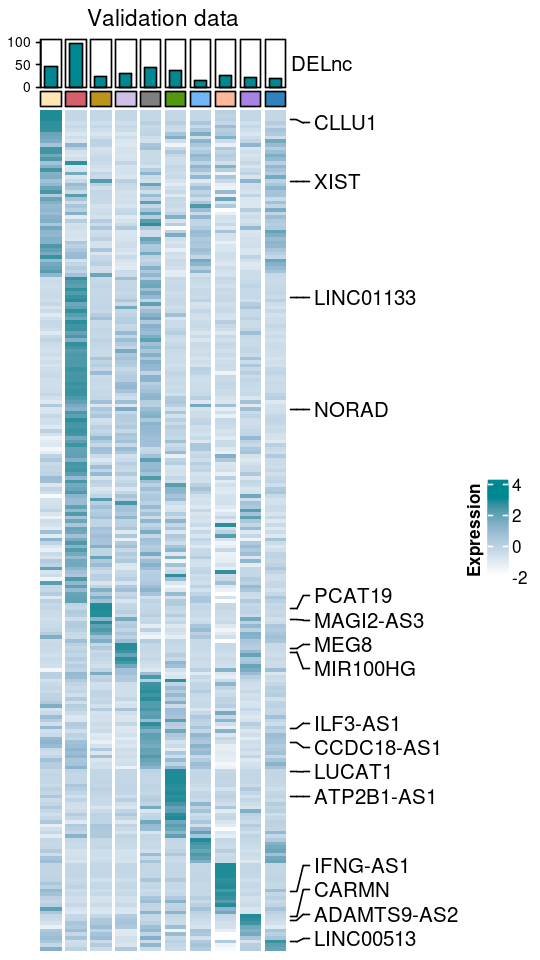

In [456]:
options(repr.plot.width=4.5, repr.plot.height=8)
ha = HeatmapAnnotation(DELnc = anno_barplot(PCs_Lnc_numStat[,3],gp = gpar(fill = "#008892"),ylim = c(0,100)),
                      cluster = anno_block(gp = gpar(fill = unique(colors_jo$primary_color))),
                      annotation_height = unit(c(1,0.3), "cm"),
                      gap = unit(1, "mm"))

Heatmap(markerExp,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_column_names = FALSE,
        show_row_names = FALSE,
        column_split = cluster_info,
        column_title = "Validation data",
        top_annotation = ha,
        right_annotation = row_anno,
        heatmap_legend_param = list(
          title='Expression',
          title_position='leftcenter-rot'),
        col = colorRamp2(c(-2, 1, 3), c("white","#92b7d1", "#008892"))
        )

In [457]:
read.csv("/mnt/public3/chaohy/pancancer/fig2/DEG_results_int/primary_cluster_markerGenes.csv", header=T) -> primary_cluster_DEGs
read.table("/mnt/public3/chaohy/pancancer/fig2/gene.bed", sep="\t", header=F) -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC
# 过滤
primary_cluster_DEGs[primary_cluster_DEGs$p_val_adj < 0.05,] %>%  dplyr::filter(pct.1>0.2 & pct.2<pct.1) -> primary_cluster_DEGs
# 提取PCs所在的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_PC$V4,] %>% arrange(cluster)  -> primary_cluster_PCs
# 提取Lnc所在的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_lncRNA$V4,] %>% arrange(cluster) -> primary_cluster_Lnc_yu

# 提取primary_cluster_Lnc_yu和primary_cluster_Lnc的交集
primary_cluster_Lnc %>% dplyr::filter(gene %in% primary_cluster_Lnc_yu$gene) %>% distinct(gene, .keep_all = TRUE) -> primary_cluster_Lnc_jo_yu
# 提取top2的Lnc
primary_cluster_Lnc_jo_yu %>% group_by(cluster) %>% top_n(1, pct.diff) %>% arrange(cluster) -> primary_cluster_Lnc_jo_yu_top2

# 对有名的Lnc去重，取top2，用于展示在图右侧
double_genes <- unique(c(primary_cluster_Lnc_jo_yu_top2$gene,primary_cluster_Lnc_top2$gene))
double_genes <- markerExp[which(rownames(markerExp) %in% double_genes),]
double_genes_pos <- which(rownames(markerExp) %in% rownames(double_genes))
row_anno <- rowAnnotation(gene=anno_mark(at=double_genes_pos, labels = rownames(double_genes)))

png 
  2

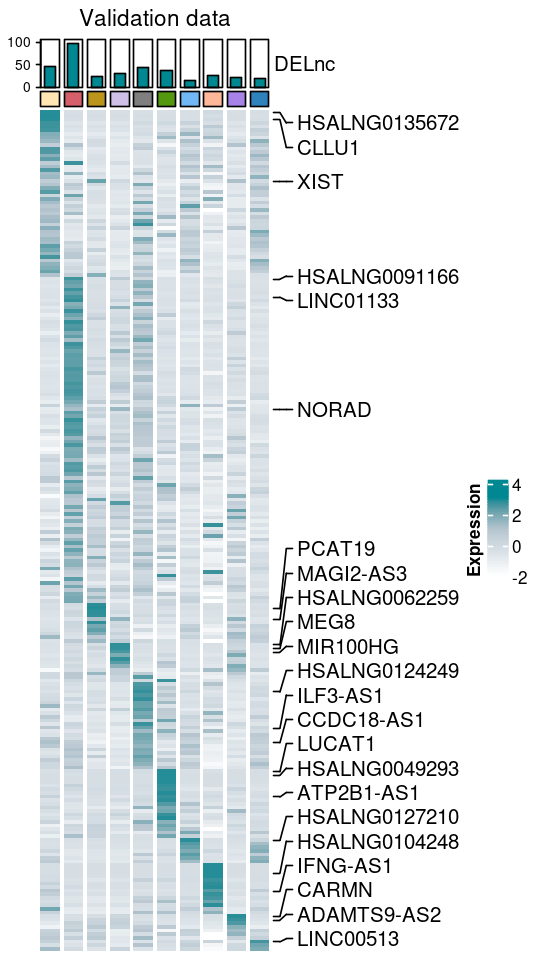

In [460]:
options(repr.plot.width=4.5, repr.plot.height=8)
Heatmap(markerExp,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_column_names = FALSE,
        show_row_names = FALSE,
        column_split = cluster_info,
        column_title = "Validation data",
        top_annotation = ha,
        right_annotation = row_anno,
        heatmap_legend_param = list(
          title='Expression',
          title_position='leftcenter-rot'),
        col = colorRamp2(c(-2, 1, 3), c("white","#b6c5cf", "#008892"))
        ) -> p4
p4
pdf("Fig2b4.pdf", width=4.5, height=8)
p4
dev.off()

In [6]:
read.table("/mnt/public3/chaohy/pancancer/fig2/gene.bed", sep="\t", header=F) -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC
head(gene_bed_lncRNA)
head(gene_bed_PC)

,V1,V2,V3,V4,V5
,<chr>,<int>,<int>,<chr>,<chr>
1,chr1,29369,34369,HSALNG0000002,lncRNA
2,chr1,17750,22750,HSALNG0000003,lncRNA
4,chr1,25939,30939,HSALNG0000004,lncRNA
5,chr1,24553,29553,HSALNG0000005,lncRNA
7,chr1,36080,41080,HSALNG0000006,lncRNA
8,chr1,50391,55391,HSALNG0000007,lncRNA


,V1,V2,V3,V4,V5
,<chr>,<int>,<int>,<chr>,<chr>
10,chr1,60418,65418,OR4F5,protein_coding
21,chr1,451696,456696,OR4F29,protein_coding
35,chr1,686672,691672,OR4F16,protein_coding
58,chr1,918927,923927,SAMD11,protein_coding
60,chr1,959308,964308,NOC2L,protein_coding
63,chr1,955583,960583,KLHL17,protein_coding


In [3]:
rdsjo <- readRDS("/mnt/public3/chaohy/pancancer/plot1cell/20240103_Integ.final_UMAP_Clean.rds")
rdsjo_meta <- readRDS("/mnt/public3/chaohy/pancancer/plot1cell/20240107_Integ.final.metadata.rds")
rdsjo@meta.data <- rdsjo_meta

In [7]:
# 计算每个基因的平均表达量
gene_expression_means <- rowMeans(rdsjo@assays$RNA@data)
# 拿到count表达矩阵
counts <- GetAssayData(object = rdsjo, slot = "counts",assay = "RNA")
nonzero <- counts > 0 # 转换为布尔值类型的数据框，方便统计
# 计算每个基因在多少个细胞中表达
expressing_cells_count <- Matrix::rowSums(nonzero)
# 计算每个基因在多少个细胞中表达的百分比
expressing_cells_percentage <- expressing_cells_count / ncol(counts) * 100

In [8]:
result_df <- data.frame(
  Gene = rownames(counts),
  gene_expression_means = gene_expression_means,
  Expressing_Cells_Percentage = expressing_cells_percentage
)

write.table(result_df,"/mnt/public3/chaohy/pancancer/fig2/fig2d_data.txt", quote = FALSE,sep = "\t",col.names = T)

In [55]:
result_df <- read.table("/mnt/public3/chaohy/pancancer/fig2/fig2d_data.txt",header = T,sep = "\t")
# 分开lncRNA 和 pc
result_lnc_df <- result_df[result_df$Gene %in% gene_bed_lncRNA$V4,] 
result_pc_df <- result_df[result_df$Gene %in% gene_bed_PC$V4 & !grepl("^MT", result_df$Gene) & !grepl("^RP", result_df$Gene),] 

# 删除基因表达均值和细胞百分比都为零的行
result_lnc_df <- result_lnc_df[result_lnc_df$gene_expression_means >= 0, ]
result_lnc_df <- result_lnc_df[result_lnc_df$Expressing_Cells_Percentage > 1, ]
result_lnc_df %>% head() 
result_lnc_df %>% dim()

result_pc_df <- result_pc_df[result_pc_df$gene_expression_means >= 0, ]
result_pc_df <- result_pc_df[result_pc_df$Expressing_Cells_Percentage > 1, ]
result_pc_df %>% head() 
result_pc_df %>% dim()

# 提取表达top10的lncRNA和pc
top_lnc_df <- top_n(result_lnc_df, 10, gene_expression_means) %>% arrange(desc(gene_expression_means))
top_pc_df <- top_n(result_pc_df, 10, gene_expression_means) %>% arrange(desc(gene_expression_means))
top_lnc_df

,Gene,gene_expression_means,Expressing_Cells_Percentage
,<chr>,<dbl>,<dbl>
HSALNG0000002,HSALNG0000002,0.01352088,1.267608
HSALNG0000022,LINC00115,0.03782179,2.798360
HSALNG0000026,HSALNG0000026,0.29111724,19.366825
HSALNG0000027,HSALNG0000027,0.04115283,3.006728
HSALNG0000030,HSALNG0000030,0.22890033,17.690992
HSALNG0000041,HSALNG0000041,0.04043324,3.686610


[1] 3592    3

,Gene,gene_expression_means,Expressing_Cells_Percentage
,<chr>,<dbl>,<dbl>
ENSG00000187634,SAMD11,0.01241019,1.177302
ENSG00000188976,NOC2L,0.16245604,13.632797
ENSG00000187961,KLHL17,0.01358258,1.368276
ENSG00000187583,PLEKHN1,0.02141217,2.277993
ENSG00000188290,HES4,0.39381788,24.603433
ENSG00000187608,ISG15,0.65478993,35.863121


[1] 12230     3

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


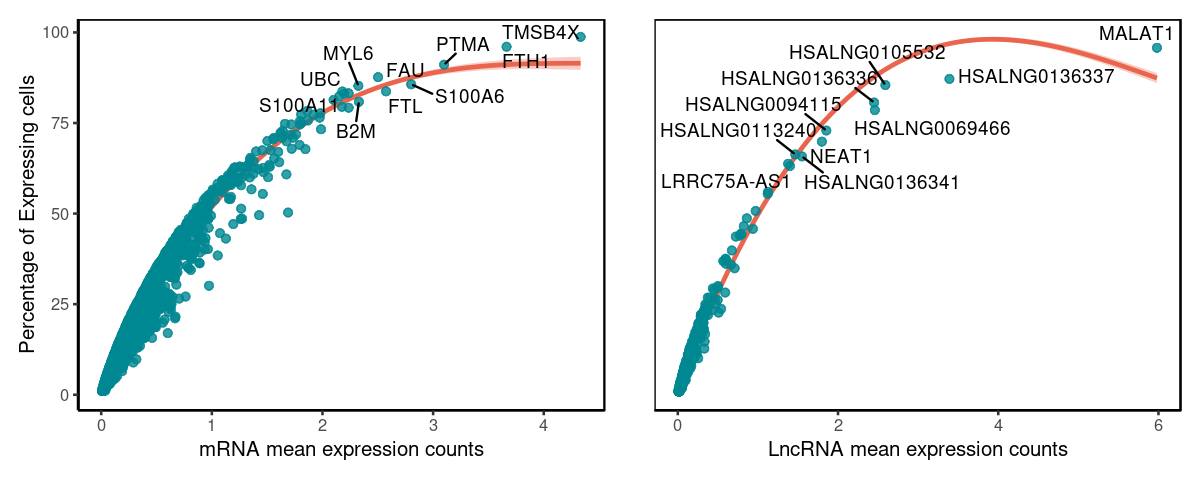

In [115]:
options(repr.plot.width=10, repr.plot.height=4)
ggplot(result_lnc_df, aes(x = gene_expression_means, y = Expressing_Cells_Percentage)) +
  geom_smooth(se = T,colour= "#e9654e",fill = "#f18672") +
  geom_point_rast(color = "#008892", size=2, alpha=0.8) + 
  geom_text_repel(data = top_lnc_df, aes(label = Gene),max.overlaps=15)+
  labs(x="LncRNA mean expression counts", y="") +
  theme_classic2() +
  theme(panel.border = element_rect(color = "black",fill = FALSE),axis.line.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank()) -> p1

ggplot(result_pc_df, aes(x = gene_expression_means, y = Expressing_Cells_Percentage)) +
  geom_smooth(se = T,colour= "#e9654e",fill = "#f18672") +
  geom_point_rast(color = "#008892", size=2, alpha=0.8) + 
  geom_text_repel(data = top_pc_df, aes(label = Gene),max.overlaps=15)+
  labs(x="mRNA mean expression counts", y="Percentage of Expressing cells") +
  theme_classic2() +
  theme(panel.border = element_rect(color = "black",fill = FALSE)) -> p2

  p2 + p1 -> p3

p3

In [82]:
top_lnc_20_df <- top_n(result_lnc_df, 10, gene_expression_means)
top_lnc_20_exp_df <- rdsjo@assays$RNA@data[rownames(rdsjo@assays$RNA@counts) %in% top_lnc_20_df$Gene,] %>% as.data.frame()
top_lnc_all_exp_df <- rdsjo@assays$RNA@data[rownames(rdsjo@assays$RNA@counts) %in% result_lnc_df$Gene,] %>% as.data.frame()

# 计算每个基因在每个细胞中的counts百分比
top_lnc_20_exp_df_p <- (top_lnc_20_exp_df / base::colSums(top_lnc_all_exp_df)) * 100
top_lnc_20_exp_df_p$Gene <- rownames(top_lnc_20_exp_df_p)
top_lnc_20_exp_df_p_m_long <- gather(top_lnc_20_exp_df_p, key="cell", value="num", -Gene)

In [83]:
# 计算每个基因在每个细胞中的counts
top_lnc_20_exp_df$Gene <- rownames(top_lnc_20_exp_df)
top_lnc_20_exp_df_m_long <- gather(top_lnc_20_exp_df, key="cell", value="num", -Gene)

# 合并数据框
merge(top_lnc_20_exp_df_m_long, top_lnc_20_exp_df_p_m_long, by=c("Gene","cell")) -> top_lnc_20_exp_df_m_long
# 设置基因排序
factor(top_lnc_20_exp_df_m_long$Gene,levels = rev(top_lnc_df$Gene)) -> top_lnc_20_exp_df_m_long$Gene

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


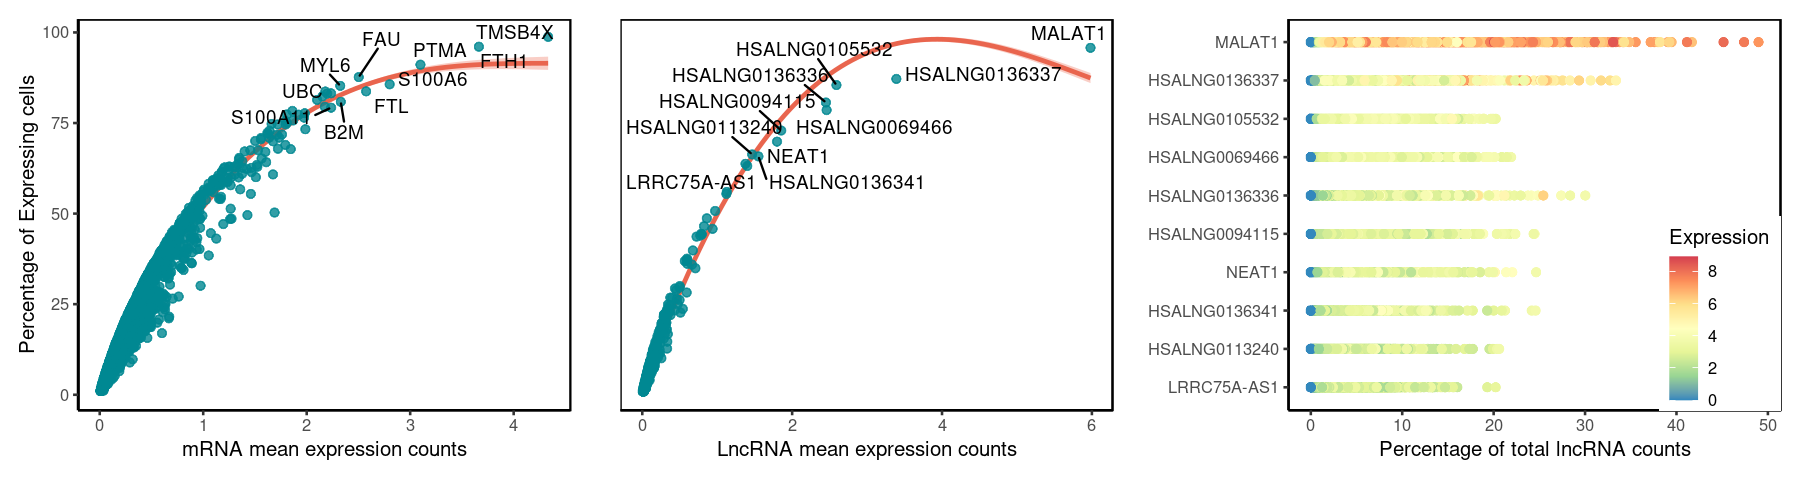

In [127]:
ggplot(top_lnc_20_exp_df_m_long, aes(x = Gene, y = num.y)) +
  geom_point_rast(aes(color = num.x), size=2) + 
  labs(x = "", y = "Percentage of total lncRNA counts", color = "Expression") +
  theme_classic2() + coord_flip() +
  theme(panel.border = element_rect(color = "black", fill = FALSE),
  legend.position = c(1, 0), legend.justification = c(1, 0)) + 
  scale_colour_distiller(palette = "Spectral") -> p4
options(repr.plot.width=15, repr.plot.height=4)
p3 + p4 -> p5

p5
ggsave("/mnt/public3/chaohy/pancancer/fig2/fig2d.pdf",p5,width =13, height =4)


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



png 
  2

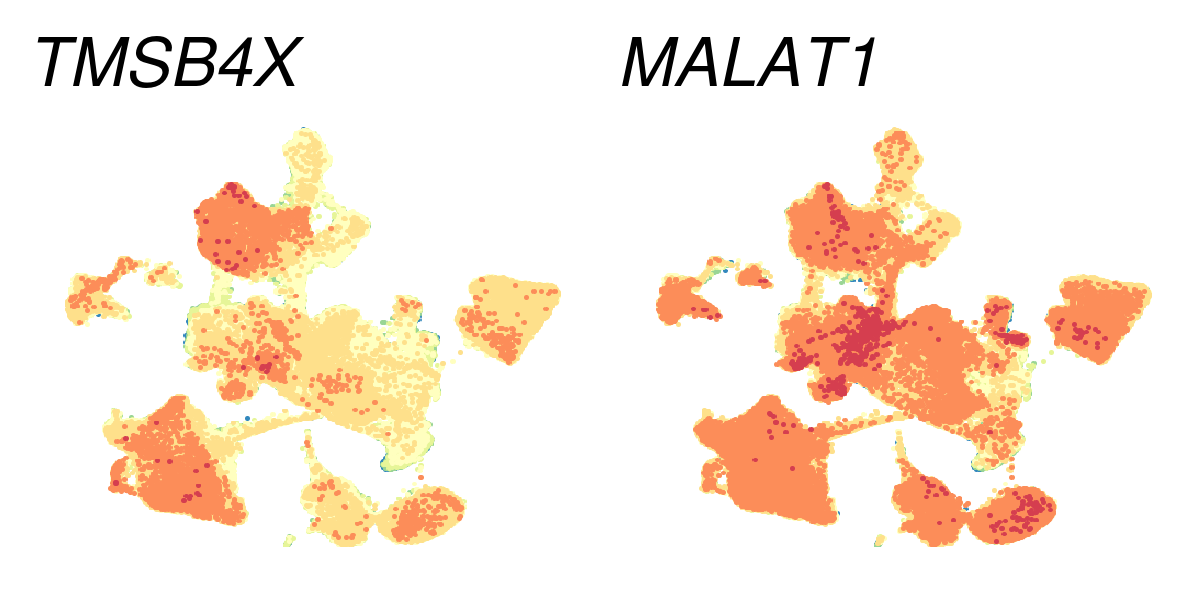

In [111]:
FeaturePlot(rdsjo, features = "MALAT1", reduction = 'umap',order=TRUE, cols=rev(brewer.spectral(7)), combine = TRUE, pt.size=2, raster = T) +
  NoLegend() +
  theme(axis.line = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), axis.title = element_blank()) +
  labs(title = bquote(italic(.("MALAT1")))) +
  theme(plot.title = element_text(hjust = 0, vjust = 0, size = 40)) -> P6

FeaturePlot(rdsjo, features = "TMSB4X", reduction = 'umap',order=TRUE, cols=rev(brewer.spectral(7)), combine = TRUE, pt.size=2, raster = T) +
  NoLegend() +
  theme(axis.line = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), axis.title = element_blank()) +
  labs(title = bquote(italic(.("TMSB4X")))) +
  theme(plot.title = element_text(hjust = 0, vjust = 0, size = 40)) -> P7

options(repr.plot.width=10, repr.plot.height=5)
(P7 + P6) + plot_layout(nrow = 1,ncol = 2)
pdf("/mnt/public3/chaohy/pancancer/fig2/Fig2d3.pdf", width=10, height=5)
(P7 + P6) + plot_layout(nrow = 1,ncol = 2)
dev.off()
